<a href="https://colab.research.google.com/github/LordLean/Machine-Learning/blob/master/Kaggle/ML_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [0]:
# Make directory and copy.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#!pip install kaggle # Install kaggle.

# Change access permissions.
!chmod 600 /root/.kaggle/kaggle.json

#!kaggle datasets list # Lists kaggle datasets.

# Download using Kaggle API.
!kaggle competitions download -c brighton-a-memorable-city

# Unzip data
!unzip additional_training.csv
!unzip training.csv
!unzip testing.csv

# List files in dir.
# !ls

  0% 0.00/19.6k [00:00<?, ?B/s]
100% 19.6k/19.6k [00:00<00:00, 17.4MB/s]
 85% 73.0M/85.7M [00:01<00:00, 43.7MB/s]
100% 85.7M/85.7M [00:01<00:00, 61.2MB/s]
  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 113MB/s]
 64% 9.00M/14.2M [00:00<00:00, 19.1MB/s]
100% 14.2M/14.2M [00:00<00:00, 26.3MB/s]
  0% 0.00/81.9k [00:00<?, ?B/s]
100% 81.9k/81.9k [00:00<00:00, 83.7MB/s]
  0% 0.00/30.0 [00:00<?, ?B/s]
100% 30.0/30.0 [00:00<00:00, 26.7kB/s]
Archive:  additional_training.csv.zip
  inflating: additional_training.csv  
Archive:  training.csv.zip
  inflating: training.csv            
Archive:  testing.csv.zip
  inflating: testing.csv             


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import TomekLinks

from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [0]:
train = pd.read_csv("/content/training.csv")
test = pd.read_csv("/content/testing.csv")
test_proportions = pd.read_csv("/content/test_proportions.csv")

Length match: True
Proportional Accuracy: 0.8309178743961353
   0    1
0  1   31
1  4  171


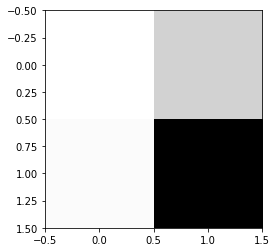

In [340]:
# Train on train, test on train[split].

split_spot = 40

train_split_train = train.iloc[:split_spot, 1:-1].to_numpy(copy=True)
train_pred_train = train.iloc[:split_spot, -1].to_numpy(copy=True)
print("Length match: {}".format(len(train_split_train) == len(train_pred_train)))

train_split_test = train.iloc[split_spot: ,1:-1].to_numpy(copy=True)
train_pred_test = train.iloc[split_spot: ,-1].to_numpy(copy=True)

X = train_split_train
y = train_pred_train 

clf = MLPClassifier(solver="lbfgs", alpha=1e-5, random_state=1)

clf.fit(X,y)

predictions = clf.predict(train_split_test)

accuracy = 0 

for i, (p1,p2) in enumerate(zip(predictions, train_pred_test)):
  if p1 == p2:
    accuracy += 1

print("Proportional Accuracy: {}".format(accuracy / len(predictions)))


conf = confusion_matrix(train_pred_test, predictions)
df = pd.DataFrame(conf)
print(df)

plt.imshow(conf, cmap="binary", interpolation="None")
#plt.axis("off")
plt.show()

In [0]:
# START--------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
train = pd.read_csv("/content/training.csv")
# ------ Set up observed predictions.

# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 
# Throughout this notebook classifiers etc are fed numpy arrays. This was due to
# certain trial classifiers prefering np array to pd etc DataFrames.

In [0]:
#@title Graphing methods { vertical-output: true }

# Graphical Functions.

# Plot bar.
def plotbargraph(trn, y_, tst_prop):

  # Data representation:

  # Training ---
  trn_c0 = np.count_nonzero(y_ == 0)
  trn_c1 = np.count_nonzero(y_ == 1)

  autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

  trn_c0 = round((trn_c0/len(y)*100),2)
  trn_c1 = round((trn_c1/len(y)*100),2)
  trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


  # Testing ---
  tst_c0 = float(test_proportions.iloc[0,0][:6])

  # Hold vals for rect labels.
  autolabel_vals.append(tst_c0*len(test))
  autolabel_vals.append((1-tst_c0)*len(test))

  tst_c0 = round((tst_c0*100),2)
  tst_c1 = 100 - tst_c0
  tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


  print("Proportions")
  print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
        "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
  print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
        "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))


  # Bar Plot.
  labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
  x = np.arange(len(labels))
  width = 0.25

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
  rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

  ax.set_ylabel("PERCENTAGE PROPORTION")
  ax.set_ylim([0,100])
  #ax.axes.get_yaxis().set_visible(False)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()


  xyz = list()
  ############
  '''https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html'''
  def autolabel(rects):
    for i, rect in enumerate(rects):
      height = rect.get_height()
      xy=(rect.get_x() + rect.get_width() / 2, height)
      xyz.append(xy)
    for i, (coord, val) in enumerate(zip(xyz,autolabel_vals)):
      ax.annotate(s=round(val),
                  xy=coord,
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')
  autolabel(rects1)
  autolabel(rects2)
  ############


  fig.tight_layout()

  plt.show()


# Plot scatter.
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 'o']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Proportions
Training data:  Class0: 15.38%   Class1: 84.62%   Proportion: 0.1818 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


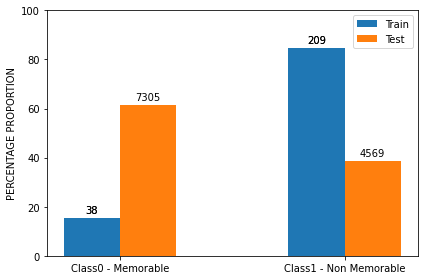

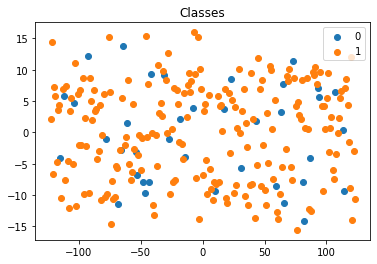

247

In [519]:
# BAR
plotbargraph(train, y, test_proportions)

# PCA -----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)

plot_2d_space(X_pca, y)

len(X_pca)

In [0]:
# START--------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
train = pd.read_csv("/content/training.csv")
# ------ Set up observed predictions.

# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True) 
# Throughout this notebook classifiers etc are fed numpy arrays. This was due to
# certain trial classifiers prefering np array to pd etc DataFrames.

# Random seed.
seed = 260498

In [480]:
# RESAMPLING.
# ----------- Up sampling minority class.

#train = pd.read_csv("/content/training.csv")

# Minority class.
minority = train.loc[train["prediction"] == 0]

# Num. of samples equal across classes.
num = len(train) - 2 * len(minority)
# Increase to match test data ratio if wanted.
num = round(num * 1.7)

print("{} rows added to training data with class0 scores.".format(num))

class0_upsampled = resample(minority,
                           replace=True,
                           n_samples=num,
                           random_state=seed
                           )

# Concat new class0 sample and original train.
train = pd.concat([train, class0_upsampled])

# Shuffle. 
train = shuffle(train, random_state=seed)


# Fix INDEX OF TRAIN DATA.
train = train.reset_index(drop=True).reset_index().drop(columns=["ID"])
train.columns.values[0] = "ID"
train["ID"] += 1


# Update target array.
# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True)

291 rows added to training data with class0 scores.


In [548]:
from imblearn.combine import SMOTETomek

v_curr = len(train)

gg = train.iloc[:,1:-1]

smt = SMOTETomek(ratio='auto', random_state=seed)
X_smt, y_smt = smt.fit_resample(gg, train_observed)

df_X_smt = pd.DataFrame(X_smt)
df_y_smt = pd.DataFrame(y_smt)

df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


train = df_total.reset_index()

v_curr = len(train) - v_curr
print("{} rows added to training data".format(v_curr))

# Shuffle. 
train = shuffle(train, random_state=seed)

# Update target array.
# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-16 rows added to training data


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from imblearn.combine import SMOTEENN

v_curr = len(train)

gg = train.iloc[:,1:-1]

smt = SMOTEENN(ratio='auto', random_state=seed)
X_smt, y_smt = smt.fit_resample(gg, train_observed)

df_X_smt = pd.DataFrame(X_smt)
df_y_smt = pd.DataFrame(y_smt)

df_total = pd.concat([df_X_smt,df_y_smt], axis=1)


train = df_total.reset_index()

v_curr = len(train) - v_curr
print("{} rows added to training data".format(v_curr))

# Shuffle. 
train = shuffle(train, random_state=seed)

# Update target array.
# Get all observed predictions 0 / 1.
train_observed = train.iloc[:, -1]
# .values()
y = train_observed.to_numpy(copy=True)

In [477]:
# Tomeks links --------------------

# # RESAMPLING.
# # ---------- Remove from majority class.

# # Removing TomekLinks.
# df_cnn = train.iloc[:, 1:-513]
# df_gist = train.iloc[:, -513:-1]

# # CNN features.
# t1 = TomekLinks(return_indices=True, ratio="majority")
# X_t1, y_t1, id_t1 = t1.fit_resample(df_cnn, train_observed)

# # GIST features.
# t2 = TomekLinks(return_indices=True, ratio="majority")
# X_t2, y_t2, id_t2 = t2.fit_resample(df_gist, train_observed)

# # List to hold Tomek's links indicies.
# index_removal = list()
# for index in np.arange(len(train)):
#   if index in id_t1:
#     pass
#   else:
#     index_removal.append(index)
#   if index in id_t2:
#     pass
#   else:
#     index_removal.append(index)


# # Remove specified indicies from train.
# train = train.drop(index_removal)

# # Get all observed predictions 0 / 1.
# train_observed = train.iloc[:, -1]
# # .values()
# y = train_observed.to_numpy(copy=True)


# print("{} rows removed from train.target['class1'] majority class.".format(len(index_removal)))

21 rows removed from train.target['class1'] majority class.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Proportions
Training data:  Class0: 89.61%   Class1: 10.39%   Proportion: 8.6246 : 1
Testing data:   Class0: 61.52%   Class1: 38.48%   Proportion: 1.5988 : 1


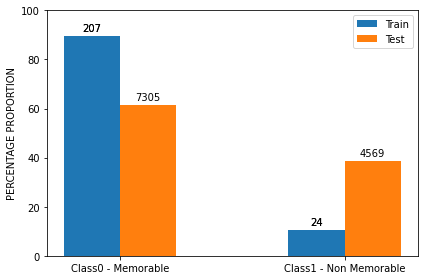

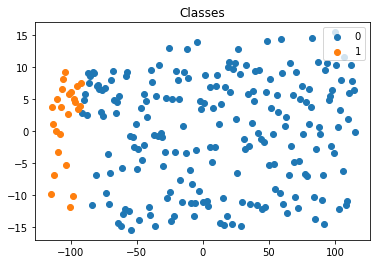

231

In [554]:
# BAR
plotbargraph(train, y, test_proportions)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)

plot_2d_space(X_pca, y)

len(X_pca)

In [0]:
# ------ Set up training and testing data.

# Split standardizer by hand.
# Training data.
df_cnn = train.iloc[:, 1:-513]
df_gist = train.iloc[:, -513:-1]

X_cnn = df_cnn.to_numpy(copy=True)
X_gist = df_gist.to_numpy(copy=True)

# Testing data.
df_test_cnn = test.iloc[:,1:-512]
df_test_gist = test.iloc[:,-512:]

test_values_cnn = df_test_cnn.to_numpy(copy=True)
test_values_gist = df_test_gist.to_numpy(copy=True)


# Set scale method.
scale_setting = 1

if scale_setting == 0:
  # Standardize training data.
  scaler = MinMaxScaler()
  X_cnn = scaler.fit_transform(X_cnn)
  test_values_cnn = scaler.transform(test_values_cnn)

  # Standardize training data.
  scaler = MinMaxScaler()
  X_gist = scaler.fit_transform(X_gist)
  test_values_gist = scaler.transform(test_values_gist)

elif scale_setting == 1:
  # Training scaling.
  mean = X_cnn.mean()
  std = X_cnn.std()

  X_cnn = (X_cnn - mean) / std
  test_values_cnn = (test_values_cnn - mean) / std

  # Testing scaling.
  mean = X_gist.mean()
  std = X_gist.std()

  X_gist = (X_gist - mean) / std
  test_values_gist = (test_values_gist - mean) / std


#Create final np arrays for training/test.
X_standardized = np.concatenate((X_cnn,X_gist),axis=1)
test_data_standardized = np.concatenate((test_values_cnn,test_values_gist),axis=1)

In [0]:
# Params:

X = X_standardized

test_data = test_data_standardized


hddn_lyrs = (100,100,100,100)
mx_itr = 100

# No diff so far.
lr = { "c" : 'constant', "i": 'invscaling', "a":'adaptive'}

In [0]:
# MLP Classifier.
clf = MLPClassifier(solver="lbfgs",
                    hidden_layer_sizes=hddn_lyrs,
                    max_iter=mx_itr,
                    alpha=1e-5,
                    random_state=1,
                    learning_rate=lr["c"]
                    )

clf.fit(X,y)

# Predictions.
predictions_final = clf.predict(test_data)

In [0]:
# # SVM Classifier.

# clf = svm.SVC(kernel="rbf")

# clf.fit(X,y)

# predictions_final = clf.predict(test_data)

# # https://scikit-learn.org/stable/modules/svm.html

In [559]:
# Calculate extremely rough "accuracy" from proportion of data correct.

class_0 = 0
class_1 = 0

for val in predictions_final:
  if val == 0:
    class_0 += 1
  elif val == 1:
    class_1 += 1

total = len(predictions_final)

pred_0 = round((class_0 / total), 4)
pred_1 = round((class_1 / total), 4) 

actual_0 = float(test_proportions.iloc[0,0][:6])
actual_1 = round((1 - actual_0),4)

dif = abs(pred_0 - actual_0)
percent_dif = dif / np.mean([pred_0,actual_0]) * 100

print("Class 0 Non memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_0,actual_0))
print("Class 1 Memorable: \nPredicted proportion: {} \nActual proportion:    {}\n".format(pred_1,actual_1))
print("Percentage difference pred_0 and actual_0 is:\n{}%\nDifference of:\n{}".format(round(percent_dif,2), round(dif,4)))

Class 0 Non memorable: 
Predicted proportion: 0.6322 
Actual proportion:    0.6152

Class 1 Memorable: 
Predicted proportion: 0.3678 
Actual proportion:    0.3848

Percentage difference pred_0 and actual_0 is:
2.73%
Difference of:
0.017


In [0]:
# 0.6152 class 0      non memorable.
# 0.3848 class 1      memorable.

In [0]:
catch this cell

SyntaxError: ignored

In [0]:
# Create and download .csv file.
rnge = np.arange(1,len(predictions_final)+1)
df = pd.DataFrame({"ID": rnge, "prediction": predictions_final})
df.to_csv("submission1.csv", index=False)

In [561]:
!ls

additional_training.csv      sample_data		  testing.csv.zip
additional_training.csv.zip  sample_valid_submission.csv  test_proportions.csv
annotation_confidence.csv    submission1.csv		  training.csv
kaggle.json		     testing.csv		  training.csv.zip


In [562]:
# Run to submit to Kaggle competition.
!kaggle competitions submit brighton-a-memorable-city -f submission1.csv -m "woo"

100% 81.9k/81.9k [00:03<00:00, 22.5kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (7.5 hours from now).


In [0]:
files.download("submission1.csv")

 <br>

In [0]:
# # Total Data.
# # Total Data.
# # Total Data.
# # Total Data.
# # Total Data.

# # Get all training values.
# train_values = train.iloc[:, 1:-1].to_numpy(copy=True)
# # Get all observed predictions.
# train_observed = train.iloc[:, -1].to_numpy(copy=True)
# # Compare to check equal length.
# print(len(train_values))
# print(len(train_observed))

# # Non-standardized Data
# X = train_values
# y = train_observed 

# # Values to test on.
# test_values = test.iloc[:,1:].to_numpy(copy=True)

# # Classifier.
# clf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(100,), max_iter=200, alpha=1e-5, random_state=1)

# clf.fit(X,y)

# # Predictions.
# predictions_final = clf.predict(test_values)

In [0]:
# pca = PCA(n_components=2)

# principalComponents = pca.fit_transform(X)

# principalDf = pd.DataFrame(data=principalComponents, columns=["PC1","PC2"])

# finalDf = pd.concat([principalDf, train.iloc[:, -1]], axis = 1)

# print(finalDf)


# labels=train.iloc[:, -1]
# cdict={0:'red',1:'green'}
# labl={0:'class0',1:'class1'}
# marker={0:'*',1:'o'}
# alpha={0:1, 1:.5}
# fig,ax=plt.subplots(figsize=(7,5))
# fig.patch.set_facecolor('white')
# for l in np.unique(labels):
#  ax.scatter(finalDf["PC1"],finalDf["PC2"],c=cdict[l],s=40,
#            label=labl[l],marker=marker[l],alpha=alpha[l])
# # for loop ends
# plt.xlabel("First Principal Component",fontsize=14)
# plt.ylabel("Second Principal Component",fontsize=14)
# plt.legend()
# plt.show()
# # please check the scatter plot of the remaining component and you will understand the difference

In [0]:
#### GROUPED TWIN AXIS BAR PLOT

# # Data representation:

# # Training ---
# trn_c0 = np.count_nonzero(y == 0)
# trn_c1 = np.count_nonzero(y == 1)

# plsdeleteAFTER = [trn_c0,trn_c1] #########
# autolabel_vals = [trn_c0,trn_c1] # Hold vals for rect labels.

# trn_c0 = round((trn_c0/len(y)*100),2)
# trn_c1 = round((trn_c1/len(y)*100),2)
# trn_bar = [trn_c0,trn_c1] # Hold vals for bar plot.


# # Testing ---
# tst_c0 = float(test_proportions.iloc[0,0][:6])

# # Hold vals for rect labels.
# autolabel_vals.append(tst_c0*len(test))
# autolabel_vals.append((1-tst_c0)*len(test))
# plsdeleteAFTER = [tst_c0*len(test),(1-tst_c0)*len(test)] #####

# tst_c0 = round((tst_c0*100),2)
# tst_c1 = 100 - tst_c0
# tst_bar = [tst_c0,tst_c1] # Hold vals for bar plot.


# print("Proportions")
# print("Training data:  Class0: {}%   Class1: {}%".format(trn_c0,trn_c1) +
#       "   Proportion: {} : 1".format(round((trn_c0/trn_c1),4)))
# print("Testing data:   Class0: {}%   Class1: {}%".format(tst_c0,tst_c1) + 
#       "   Proportion: {} : 1".format(round((tst_c0/tst_c1),4)))


# # Bar Plot.
# labels = ["Class0 - Memorable", "Class1 - Non Memorable"]
# x = np.arange(len(labels))
# width = 0.25

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, trn_bar, width, label='Train')
# rects2 = ax.bar(x + width/2, tst_bar, width, label='Test')

# colour = "tab:blue"
# ax.set_ylabel("TRAINING DATA", color=colour)
# ax.set_ylim([0,100])
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# ax2 = ax.twinx()
# colour = "tab:orange"
# ax2.set_ylabel("TESTING DATA", color=colour)
# ax2.tick_params(axis="y", color=colour)

# ############
# # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
# def autolabel(rects):
#   for i, rect in enumerate(rects):
#     height = rect.get_height()
#     ax.annotate('{}%'.format(height),
#                 xy=(rect.get_x() + rect.get_width() / 2, height),
#                 xytext=(0, 3),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom')
# ############


# autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

# plt.show()